<a href="https://colab.research.google.com/github/CostiaB/Birds_Detection/blob/main/YOLO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns


import matplotlib.patches as patches
from collections import Counter
import os
import random
import xml.etree.ElementTree as ET
import torch
import torchvision
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset,DataLoader
from PIL import Image

import sys
import torch.optim as optim
from tqdm.notebook import tqdm
np.seterr(divide='ignore', invalid='ignore')

{'divide': 'warn', 'invalid': 'warn', 'over': 'warn', 'under': 'ignore'}

In [2]:
device = torch.device ("cuda:0" if torch.cuda.is_available () else "cpu")

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
path_annotations = "/content/drive/MyDrive/birds1/birds/annotations/" 
images_dir = "/content/drive/MyDrive/birds1/birds/"

#path_annotations = "/home/costia/birds/annotations/" #"/home/costia/birds_project/detect/annotations/check/"
#images_dir = "/home/costia/birds/"

In [5]:
labels_dict = {1: 'Eurasian_jay',
 2: 'great_spotted_woodpecker',
 3: 'greenfinch',
 4: 'blue_tit',
 5: 'Carduelis',
 6: 'common_redpoll',
 7: 'great_tit',
 8: 'bullfinch',
 9: 'Eurasian_siskin',
 10: 'Eurasian_tree_sparrow',
 11: 'hawfinch',
 12: 'willow_tit',
 13: 'Fieldfare',
 14: 'Common_chaffinch',
 15: 'Common_linnet'}
n_classes = len(labels_dict)  # number of classes
color_dict = {i:color/255 for i,color in enumerate(np.random.uniform(0, 255, size=(n_classes, 3)))}

In [8]:
def convert_2_yolo(size, box):
    dw = 1./(size[0])
    dh = 1./(size[1])
    x_min, y_min, x_max, y_max = box
    x = (x_min + x_max)/2.0 - 1
    y = (y_min + y_max)/2.0 - 1
    w = x_max - x_min
    h = y_max - y_min
    x = x*dw
    w = w*dw
    y = y*dh
    h = h*dh
    return (x, y , w, h)

def xml_transform(xml_path, im_size = None):
    xml = ET.parse(xml_path)
    root = xml.getroot()
    img_name = root[1].text
    labels, boxes = [], [] 
    
    size = (float(root[4][0].text), float(root[4][1].text))
    #print("(w,h)", size, img_name) # test info
    for obj in root.iter('object'):
        label = obj[0].text
        if label == 'Common chaffinch':
            label = 'Common_chaffinch'
        try:
            label = [label == species for species in labels_dict.values()].index(True) + 1
        except ValueError:
            print(xml_path)
                
        labels.append(label)
        box = [int(coord.text) for coord in obj[4]]
        if im_size:
            dw = im_size[0]/(size[0])
            dh = im_size[1]/(size[1])
            box = [int(box[0]*dw), int(box[1]*dh), int(box[2]*dw), int(box[3]*dh)]
            box = convert_2_yolo(im_size, box)
        else:
            box = convert_2_yolo(size, box)
        boxes.append(box)
        
    target = {'boxes' : torch.as_tensor(boxes, dtype=torch.float32),
              'labels' : labels}
    return img_name, target



def count_classes(path_annotations):
    target_list = []
    xml_list = [os.path.join(path_annotations, file) for file in os.listdir(path_annotations)]
    for xml in xml_list:
        _, target = xml_transform(xml)
        target_list += target['labels']
    return Counter(target_list) 
    

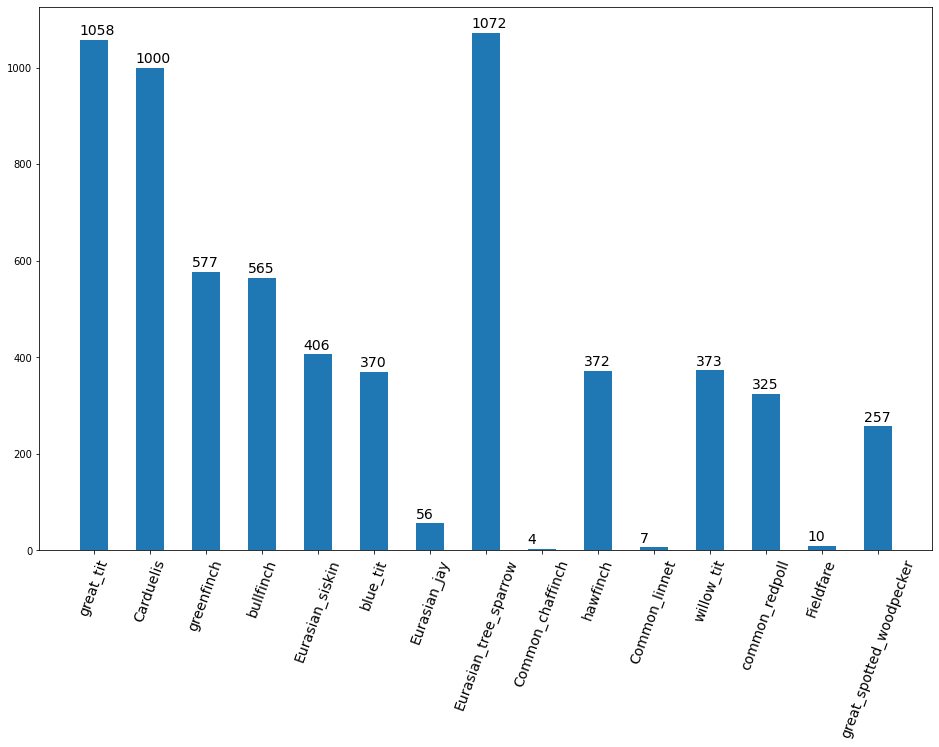

In [9]:
#class distribution
labels, values = zip(*count_classes(path_annotations).items())
indexes = np.arange(len(labels))
#add name of species
labels = [labels_dict[lab] for lab in labels if lab != 0]
width = 0.5
plt.figure(figsize = (16,10))
plt.bar(indexes, values, width, align='edge')
plt.xticks(indexes + width * 0.5, labels, rotation=70, fontsize=14)
for ind,val in zip(indexes, values):
    plt.text(x=ind, y =val+10, s=str(val), fontdict=dict(fontsize=14), color = 'black')
plt.show()

In [13]:
def collate_fn(batch):
    return tuple(zip(*batch))


In [14]:
def train_val_split(path_annotations, val_size=.25, seed=233):
    random.seed(seed)
    path_list = [os.path.join(path_annotations, path) for path in os.listdir(path_annotations)]
    val_size = int(len(path_list)*val_size)
    val_paths = random.sample(path_list, val_size)
    train_paths = list(set(path_list) - set(val_paths)) 
    return train_paths, val_paths
    

In [15]:
def plot_detection(img, info, with_text=False, conf_lvl=0.3, swap=True,
                   color_dict=color_dict):
    fig, ax = plt.subplots()
    img = img.permute((1, 2, 0))

    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img.numpy() + mean

    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    img = np.clip(img, 0, 1)
    
    if swap:
        img = img.swapaxes(0,1)
        img = img.swapaxes(1,2)
        img = np.clip(img, 0, 1)
    ax.imshow(img)
    dh, dw, _ = img.shape
    
    flag = False
    if 'scores' in info.keys():
        mask = info['scores'] >= conf_lvl
        confidences = info['scores'][mask]
        boxes = info['boxes'][mask]
        labels = info['labels'][mask]
        
        flag = True
    else:
        
        boxes = info['boxes']
        labels = info['labels']
    
    for i, box in enumerate(boxes):
        '''
        x_min, y_min, x_max, y_max = box
        height = y_max - y_min
        width = x_max - x_min
        '''
        x_center, y_center, width, height = box
        x_min = x_center - width/2
        y_min = y_center - height/2
        width = int(width*dw)
        height = int(height*dh)
        x_min = int(x_min*dw)
        y_min = int(y_min*dh)
        label = labels_dict [int(labels[i])]
        color = color_dict[int(labels[i])]
        rect = patches.Rectangle((x_min, y_min), width, height,
                                 linewidth=2, edgecolor=color,
                                 facecolor='none')
        ax.add_patch(rect)
        if with_text:
            if flag:
                text = '{} {:.0f}%'.format(label, confidences[i]*100)
            else:
                text = '{}'.format(label)
            ax.text(x_min, y_min, text,
                    bbox=dict(facecolor='white', alpha=0.5))
    plt.show()

In [16]:
im_size = (640, 480)
train_transform = transforms.Compose([
                            transforms.ToTensor(),
                            transforms.Resize(im_size),
                            transforms.ColorJitter(brightness=.5, hue=.3),
                            transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),
                            transforms.RandomInvert(),
                            transforms.RandomAdjustSharpness(sharpness_factor=2),
                            transforms.RandomAutocontrast(),
                            #transforms.RandomEqualize(),
                            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
                            

                        ])

val_transform = transforms.Compose([
                            transforms.ToTensor(),
                            transforms.Resize(im_size),
                            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                        ])

In [19]:
class BirdsDataset(torch.utils.data.Dataset):
    def __init__(self, transform, annotation_paths, images_dir):
        self.transform = transform
        self.annotation_paths = annotation_paths
        self.images_dir = images_dir
        
    def __len__(self):
        return len(self.annotation_paths)
    
    def __getitem__(self, idx):
        path = self.annotation_paths[idx]
        img_name, target = xml_transform(path, im_size)
        target['labels']  = torch.as_tensor(target['labels'], dtype=torch.int64) 
        img_path = os.path.join(self.images_dir, img_name)
        img = Image.open(img_path).convert('RGB')
        img = self.transform(img)
        
        return img, target
        
        
        

In [20]:
batch_size = 9
val_size = 0.25
train_ann_path, val_ann_path = train_val_split(path_annotations, val_size=val_size, seed=779)

train_dataset = BirdsDataset(transform=train_transform,
                            annotation_paths = train_ann_path,
                            images_dir  = images_dir)

val_dataset = BirdsDataset(transform=val_transform,
                            annotation_paths = val_ann_path,
                            images_dir  = images_dir)

train_batch_gen = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size, 
                                              shuffle = True,
                                            collate_fn=collate_fn)

val_batch_gen = torch.utils.data.DataLoader(val_dataset, batch_size = batch_size,
                                            shuffle = True,
                                            collate_fn=collate_fn)

dataloaders = {'train': train_batch_gen,
               'val': val_batch_gen}

dataset_sizes = {'train' : len(train_dataset),
                 'val' : len(val_dataset)}

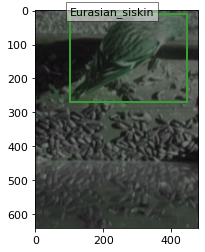

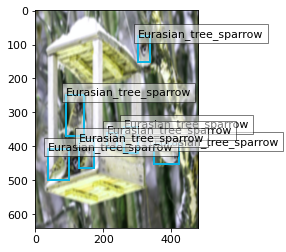

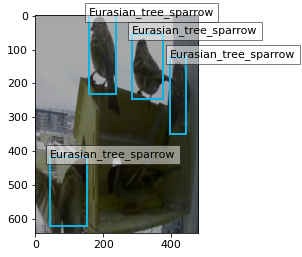

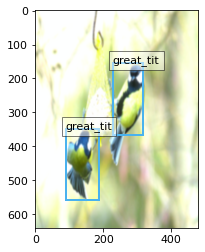

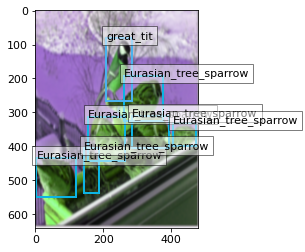

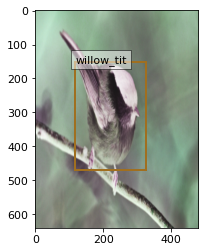

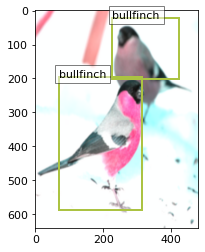

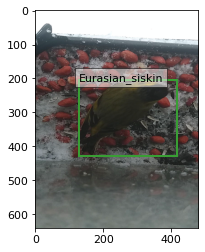

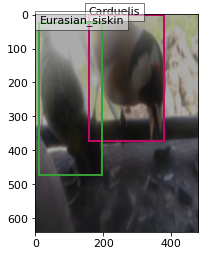

In [21]:
imgs, boxes = next(iter(train_batch_gen))
for img, info in zip(imgs, boxes):
    plot_detection(img, info, with_text=True, swap = False,
                   color_dict=color_dict)


In [11]:
model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)
model.to(device)

Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
requirements: PyYAML>=5.3.1 not found and is required by YOLOv5, attempting auto-update...
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/

requirements: 1 package updated per /root/.cache/torch/hub/ultralytics_yolov5_master/requirements.txt
requirements: ⚠️ Restart runtime or rerun command for updates to take effect

YOLOv5 🚀 2022-7-18 Python-3.7.13 torch-1.12.0+cu113 CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


AutoShape(
  (model): DetectMultiBackend(
    (model): Model(
      (model): Sequential(
        (0): Conv(
          (conv): Conv2d(3, 32, kernel_size=(6, 6), stride=(2, 2), padding=(2, 2))
          (act): SiLU(inplace=True)
        )
        (1): Conv(
          (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (act): SiLU(inplace=True)
        )
        (2): C3(
          (cv1): Conv(
            (conv): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
            (act): SiLU(inplace=True)
          )
          (cv2): Conv(
            (conv): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
            (act): SiLU(inplace=True)
          )
          (cv3): Conv(
            (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
            (act): SiLU(inplace=True)
          )
          (m): Sequential(
            (0): Bottleneck(
              (cv1): Conv(
                (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
           